# Overview of the project

###The Makridakis Open Forecasting Center (MOFC) at the University of Nicosia conducts cutting-edge forecasting research and provides business forecast training. It helps companies achieve accurate predictions, estimate the levels of uncertainty, avoiding costly mistakes, and apply best forecasting practices. The MOFC is well known for its Makridakis Competitions, the first of which ran in the 1980s.



## Aim of the project:

###This data is  hierarchical sales data from Walmart, the world’s largest company by revenue, and the aim of this project is  to forecast daily sales for the next 28 days and to make uncertainty estimates for these forecasts. 

###The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Together, this robust dataset can be used to improve forecasting accuracy.


## Description of the data provided

###calendar.csv - Contains information about the dates on which the products are sold.
###sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
###sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
###sell_prices.csv - Contains information about the price of the products sold per store and date.
###sales_train_evaluation.csv - Includes sales [d_1 - d_1941] 

## Importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

import warnings
warnings.filterwarnings("ignore")


In [ ]:

import time
import math
import datetime


# Import widgets
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

from math import log, floor
from sklearn.neighbors import KDTree

import seaborn as sns
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller



## Data Importation

In [ ]:

# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/sales/m5-forecasting-uncertainty.zip

Archive:  /content/drive/MyDrive/sales/m5-forecasting-uncertainty.zip
  inflating: calendar.csv            
  inflating: sales_train_evaluation.csv  
  inflating: sales_train_validation.csv  
  inflating: sample_submission.csv   
  inflating: sell_prices.csv         


In [ ]:
calendar_df = pd.read_csv('calendar.csv')
train_df = pd.read_csv('sales_train_evaluation.csv')
#val_df = reduce_mem_usage(pd.read_csv('sales_train_validation.csv'))
prices_df = pd.read_csv('sell_prices.csv')
sales_val_df = pd.read_csv('sales_train_validation.csv')
sales_eval_df = pd.read_csv('sales_train_evaluation.csv')

### We define a function to enable us to efficiently manage our memory

In [ ]:

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']     
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train_df = reduce_mem_usage(train_df)

Mem. usage decreased to 96.13 Mb (78.8% reduction)


In [ ]:
prices_df = reduce_mem_usage(prices_df)

Mem. usage decreased to 130.48 Mb (37.5% reduction)


### Let us define another function to help us with  plotting of time series data

In [ ]:
# Helper functions
def plot_time_series(data, ax=None, show=False):
    """Plot time series data."""
    if ax is None:
        fig, ax = plt.subplots()
    for ind in data.index:
        ax.plot([int(col.split('_')[-1]) for col in data.columns], 
                data.loc[ind].values, '-', label=ind)
    ax.legend(loc='best')
    ax.set_xlabel('day number')
    ax.set_ylabel('items sold')
    if show:
        plt.show(block=False)

def plot_aggregation(data):
    """Make plots over two time periods."""
    plot_time_series(data)
    plot_time_series(data[data.columns[-3*28:]])

### We now observe some of the columns of the data

In [ ]:
train_df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938',
       'd_1939', 'd_1940', 'd_1941'],
      dtype='object', length=1947)

In [ ]:
prices_df.columns

Index(['store_id', 'item_id', 'wm_yr_wk', 'sell_price'], dtype='object')

In [ ]:
train_df=train_df.fillna(0)

### Making a description of the categorical columns present in the dataset

In [ ]:
# Get column groups
categorical_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
ts_cols = [col for col in train_df.columns if col not in categorical_cols]
print(ts_cols)
ts_dict = {t: int(t[2:]) for t in ts_cols[1:]}

# Describe data
print('  unique forecasts: %i' % len(train_df.id.unique()))
for col in categorical_cols:
    print('   N_unique %s: %i' % (col, train_df[col].nunique()))

['id', 'd_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10', 'd_11', 'd_12', 'd_13', 'd_14', 'd_15', 'd_16', 'd_17', 'd_18', 'd_19', 'd_20', 'd_21', 'd_22', 'd_23', 'd_24', 'd_25', 'd_26', 'd_27', 'd_28', 'd_29', 'd_30', 'd_31', 'd_32', 'd_33', 'd_34', 'd_35', 'd_36', 'd_37', 'd_38', 'd_39', 'd_40', 'd_41', 'd_42', 'd_43', 'd_44', 'd_45', 'd_46', 'd_47', 'd_48', 'd_49', 'd_50', 'd_51', 'd_52', 'd_53', 'd_54', 'd_55', 'd_56', 'd_57', 'd_58', 'd_59', 'd_60', 'd_61', 'd_62', 'd_63', 'd_64', 'd_65', 'd_66', 'd_67', 'd_68', 'd_69', 'd_70', 'd_71', 'd_72', 'd_73', 'd_74', 'd_75', 'd_76', 'd_77', 'd_78', 'd_79', 'd_80', 'd_81', 'd_82', 'd_83', 'd_84', 'd_85', 'd_86', 'd_87', 'd_88', 'd_89', 'd_90', 'd_91', 'd_92', 'd_93', 'd_94', 'd_95', 'd_96', 'd_97', 'd_98', 'd_99', 'd_100', 'd_101', 'd_102', 'd_103', 'd_104', 'd_105', 'd_106', 'd_107', 'd_108', 'd_109', 'd_110', 'd_111', 'd_112', 'd_113', 'd_114', 'd_115', 'd_116', 'd_117', 'd_118', 'd_119', 'd_120', 'd_121', 'd_122', 'd_

 We can see from the above that we have 3049 unique items, 7 departments, Three main categories, 10 stores and lastly 3 states in our data

## Let us take a subset of the data and perform feature engineering

Under this section we will seek to:

1) Create new features and find their relationship with the sales

2) Remove redundant(useless) features

3) Remove outliers where necessary

4) Deal with Nan Values

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int16(1317), int8(624), object(6)
memory usage: 96.1+ MB


In [ ]:
len(train_df)

30490

In [ ]:
train_df_sub = train_df#.loc[:2000,:]

In [ ]:
prices_df_sub = prices_df#.loc[:2000, :]

### A function is defined below to help with the merging of dataframes

In [ ]:

def merge_by_frames(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = pd.DataFrame(merged_gf).merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1



In [ ]:
TARGET = 'sales'         # Our main target
END_TRAIN = 1913         # Last day in train set, we will extend the dataframe for the next 28 days
MAIN_INDEX = ['id','d']

### We will create a new data frame and transpose the horizontal day columnns to one new column and merge the train, prices and calendar data frames

In [ ]:

index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
new_df = pd.melt(train_df_sub, 
                  id_vars = index_columns, 
                  var_name = 'd', 
                  value_name = TARGET)

# For predictions' sake we will create a new dataframe and join to the 
# current one for predictions over  the next 28 days 

grid = pd.DataFrame()  # create an empty dataframe and fill in with values
for i in range(1,29):
    temp_df = train_df_sub[index_columns]
    temp_df = temp_df.drop_duplicates()
    temp_df['d'] = 'd_'+ str(END_TRAIN+i)
    temp_df[TARGET] = np.nan
    grid = pd.concat([grid,temp_df])

new_df = pd.concat([new_df,grid])
new_df = new_df.reset_index(drop=True)

# SAVING MEMORY by deleting the frames below
del temp_df, grid
del train_df_sub

new_df.reset_index(drop=True, inplace=True)

# convert the string types to category to save space
for col in index_columns:
    new_df[col] = new_df[col].astype('category')


We make the following assumptions:
1. Leading Zero values in the train data frame means the item was not available in the store and hence out of stock

2. Prices in the store are set at the beggining of the week

In [ ]:
# We will create a new data frame  and pick the minimum of the 
release_df = prices_df_sub.groupby(['store_id','item_id'])['wm_yr_wk'].agg(['min']).reset_index()
release_df.columns = ['store_id','item_id','release']

# Now we can merge release_df
new_df = merge_by_frames(new_df, release_df, ['store_id','item_id'])
del release_df

# We want to remove some "zeros" rows
# from grid_df 
# to do it we need wm_yr_wk column let's merge partly calendar_df to have it
new_df = merge_by_frames(new_df, calendar_df[['wm_yr_wk','d']], ['d'])
                      
# Now we can cutoff some rows 
# and safe memory 
####grid_df = grid_df[grid_df['wm_yr_wk']>=grid_df['release']]
new_df = new_df.reset_index(drop=True)

# Let's check our memory usage
#print("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

# Should we keep release week 

new_df['release'] = new_df['release'] - new_df['release'].min()




In [ ]:
new_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,224.0,11101
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,20.0,11101
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,300.0,11101
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,5.0,11101
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,16.0,11101


In [ ]:
print('Save Part 1')

# We have our BASE grid ready
# and can save it as pickle file
# for future use (model training)
new_df.to_pickle('grid_part_1.pkl')

print('Size:', new_df.shape)

Save Part 1
Size: (3939969, 10)


### Finanlly we will merge with the prices data

In [ ]:
# replacing all the missing values in sell_prices with the mean
prices_df_sub['sell_price'] = prices_df_sub['sell_price'].fillna(prices_df_sub.groupby(['store_id','item_id',])['sell_price'].transform('mean'))

# for every store and every item in that store we determine the  aggregates max,min,std and mean of price
prices_df_sub['price_max'] = prices_df_sub.groupby(['store_id','item_id'])['sell_price'].transform('max')
prices_df_sub['price_min'] = prices_df_sub.groupby(['store_id','item_id'])['sell_price'].transform('min')
prices_df_sub['price_std'] = prices_df_sub.groupby(['store_id','item_id'])['sell_price'].transform('std')
prices_df_sub['price_mean'] = prices_df_sub.groupby(['store_id','item_id'])['sell_price'].transform('mean')

# price normalization (min/max scaling)
prices_df_sub['price_norm'] = prices_df_sub['sell_price']/prices_df_sub['price_max']

# Some items are can be inflation dependent
# and some items are very "stable"
prices_df_sub['price_nunique'] = prices_df_sub.groupby(['store_id','item_id'])['sell_price'].transform('nunique')
prices_df_sub['item_nunique'] = prices_df_sub.groupby(['store_id','sell_price'])['item_id'].transform('nunique')

# I would like some "rolling" aggregations
# but would like months and years as "window"
calendar_prices = calendar_df[['wm_yr_wk','month','year']]
calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
prices_df_sub = prices_df_sub.merge(calendar_prices[['wm_yr_wk','month','year']], on=['wm_yr_wk'], how='left')
del calendar_prices

# Now we can add price "momentum" (some sort of)
# Shifted by week 
# by month mean
# by year mean
prices_df_sub['price_momentum'] = prices_df_sub['sell_price']/prices_df_sub.groupby(['store_id','item_id'])['sell_price'].transform(lambda x: x.shift(1))
prices_df_sub['price_momentum_m'] = prices_df_sub['sell_price']/prices_df_sub.groupby(['store_id','item_id','month'])['sell_price'].transform('mean')
prices_df_sub['price_momentum_y'] = prices_df_sub['sell_price']/prices_df_sub.groupby(['store_id','item_id','year'])['sell_price'].transform('mean')


del prices_df_sub['month'], prices_df_sub['year']

In [ ]:


# Merge Prices
original_columns = list(new_df)
new_df = new_df.merge(prices_df_sub, on=['store_id','item_id','wm_yr_wk'], how='left')
keep_columns = [col for col in list(new_df) if col not in original_columns]
new_df = new_df[MAIN_INDEX+keep_columns]
new_df = reduce_mem_usage(new_df)

# Save part 2
new_df.to_pickle('grid_part_2.pkl')
print('Size:', new_df.shape)

# We don't need prices_df anymore
del prices_df

# We can remove new columns
# or just load part_1
grid_df = pd.read_pickle('grid_part_1.pkl')

Mem. usage decreased to 150.38 Mb (31.0% reduction)
Size: (3939969, 13)


### We will now merge with our calendar data

In [ ]:

new_df = new_df[MAIN_INDEX]

# Merge calendar partly
icols = ['date',
         'd',
         'event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI',
         'wday']

new_df = new_df.merge(calendar_df[icols], on=['d'], how='left')
new_df.event_type_1 = new_df.event_type_1.fillna('normal_day')
new_df.event_type_2 = new_df.event_type_2.fillna('normal_day')
new_df.event_name_1 = new_df.event_name_1.fillna('normal_day')
new_df.event_name_2 = new_df.event_name_2.fillna('normal_day')




#Adding feature 'month_day' which tells day of the month
m=new_df["date"].tolist()
m=[i.split("-")[2] for i in m]
new_df["month_day"]=m
new_df['month_day']=new_df['month_day'].astype(np.int8)



#Adding feature 'month_week_number' which tells which week of the month
new_df['month_week_number']=(new_df['month_day']-1) // 7 + 1 
new_df['month_week_number']=new_df['month_week_number'].astype(np.int8)

#Adding feature 'events_per_day' which tells us number of events on particular day
f=lambda x: 0 if x=='normal_day' else 1
new_df['events_per_day']=new_df['event_type_1'].map(f) 
index=new_df.index 
indices=index[new_df['event_type_2']!='normal_day'].tolist()
for i in indices:
  new_df['events_per_day'][i]+=1
new_df['events_per_day']=new_df['events_per_day'].astype(np.int8)


# Minify data
# 'snap_' columns we can convert to bool or int8
icols = ['event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI',
         'wday']
for col in icols:
    new_df[col] = new_df[col].astype('category')

# Convert to DateTime
new_df['date'] = pd.to_datetime(new_df['date'])

# Make some features from date
new_df['tm_d'] = new_df['date'].dt.day.astype(np.int8)

#Adding feature 'is_weekend' which tells about that day is weekend or not

f=lambda x: 1 if x<=2 else 0
new_df['is_weekend']=new_df['wday'].map(f) 
new_df['is_weekend']=new_df['is_weekend'].astype(np.int8)
new_df['tm_w'] = new_df['date'].dt.week.astype(np.int8)
new_df['tm_m'] = new_df['date'].dt.month.astype(np.int8)
new_df['tm_y'] = new_df['date'].dt.year
new_df['tm_y'] = (new_df['tm_y'] - new_df['tm_y'].min()).astype(np.int8)
new_df['tm_wm'] = new_df['tm_d'].apply(lambda x: ceil(x/7)).astype(np.int8)

new_df['tm_dw'] = new_df['date'].dt.dayofweek.astype(np.int8)
new_df['tm_w_end'] = (new_df['tm_dw']>=5).astype(np.int8)


In [ ]:
del new_df['date']

In [ ]:
# Safe  final part
new_df.to_pickle('new_df.pkl')
print('Size:', new_df.shape)

# We don't need calendar_df anymore
#del calendar_df
#del grid_df

Size: (3939969, 21)


In [ ]:
########################### Some additional cleaning
#################################################################################

## Part 1
# Convert 'd' to int
new_df = pd.read_pickle('grid_part_1.pkl')
new_df['d'] = new_df['d'].apply(lambda x: x[2:]).astype(np.int16)



In [ ]:
# Remove 'wm_yr_wk'
# as test values are not in train set
del new_df['wm_yr_wk']
new_df.to_pickle('grid_part_1.pkl')

del new_df

In [ ]:
import pandas as pd
# Now we have 3 sets of features
new_df = pd.concat([pd.read_pickle('grid_part_1.pkl'),
                     pd.read_pickle('grid_part_2.pkl').iloc[:,2:],
                     pd.read_pickle('new_df.pkl').iloc[:,2:]],
                     axis=1)
                     


In [ ]:
# Let's check again memory usage
#print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(grid_df.memory_usage(index=True).sum())))
print('Size:', new_df.shape)

# 2.5GiB + is is still too big to train our model
# (on kaggle with its memory limits)
# and we don't have lag features yet
# But what if we can train by state_id or shop_id?
state_id = 'CA'
new_df = new_df[new_df['state_id']==state_id]
#print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(grid_df.memory_usage(index=True).sum())))
#           Full Grid:   1.2GiB

store_id = 'CA_1'
new_df = new_df[new_df['store_id']==store_id]
#print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(grid_df.memory_usage(index=True).sum())))
#           Full Grid: 321.2MiB



Size: (3939969, 39)


In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3939969 entries, 0 to 3939968
Data columns (total 39 columns):
 #   Column             Dtype   
---  ------             -----   
 0   id                 category
 1   item_id            category
 2   dept_id            category
 3   cat_id             category
 4   store_id           category
 5   state_id           category
 6   d                  int16   
 7   sales              float64 
 8   release            float64 
 9   sell_price         float16 
 10  price_max          float16 
 11  price_min          float16 
 12  price_std          float16 
 13  price_mean         float16 
 14  price_norm         float16 
 15  price_nunique      float16 
 16  item_nunique       float16 
 17  price_momentum     float16 
 18  price_momentum_m   float16 
 19  price_momentum_y   float16 
 20  event_name_1       category
 21  event_type_1       category
 22  event_name_2       category
 23  event_type_2       category
 24  snap_CA            categ

In [ ]:
new_df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,sell_price,...,month_week_number,events_per_day,tm_d,is_weekend,tm_w,tm_m,tm_y,tm_wm,tm_dw,tm_w_end
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,224.0,NaN,...,5,0,29,1,4,1,0,5,5,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,20.0,NaN,...,5,0,29,1,4,1,0,5,5,1
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,300.0,NaN,...,5,0,29,1,4,1,0,5,5,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,5.0,NaN,...,5,0,29,1,4,1,0,5,5,1
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,16.0,NaN,...,5,0,29,1,4,1,0,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939964,FOODS_2_170_CA_1_evaluation,FOODS_2_170,FOODS_2,FOODS,CA_1,CA,1941,NaN,NaN,NaN,...,4,0,22,1,20,5,5,4,6,1
3939965,FOODS_2_171_CA_1_evaluation,FOODS_2_171,FOODS_2,FOODS,CA_1,CA,1941,NaN,NaN,NaN,...,4,0,22,1,20,5,5,4,6,1
3939966,FOODS_2_172_CA_1_evaluation,FOODS_2_172,FOODS_2,FOODS,CA_1,CA,1941,NaN,NaN,NaN,...,4,0,22,1,20,5,5,4,6,1
3939967,FOODS_2_173_CA_1_evaluation,FOODS_2_173,FOODS_2,FOODS,CA_1,CA,1941,NaN,NaN,NaN,...,4,0,22,1,20,5,5,4,6,1


In [ ]:
new_df.isna().sum()

id                         0
item_id                    0
dept_id                    0
cat_id                     0
store_id                   0
state_id                   0
d                          0
sales                  56028
release              3922248
sell_price           3926002
price_max            3926002
price_min            3926002
price_std            3926002
price_mean           3926002
price_norm           3926002
price_nunique        3926002
item_nunique         3926002
price_momentum       3926065
price_momentum_m     3926002
price_momentum_y     3926002
event_name_1               0
event_type_1               0
event_name_2               0
event_type_2               0
snap_CA                    0
snap_TX                    0
snap_WI                    0
wday                       0
month_day                  0
month_week_number          0
events_per_day             0
tm_d                       0
is_weekend                 0
tm_w                       0
tm_m          

In [ ]:
new_df.sell_price.count()

13967

## We will apply label encoding to categorical columns

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
cats =['event_name_1','event_type_1','event_name_2','event_type_2','id','item_id','dept_id','cat_id','store_id','state_id']

In [ ]:
# Encode labels in column 'store_id,cat_id,state_id'.
for x in cats:
  new_df[x]= le.fit_transform(new_df[x])
  
  new_df[x].unique()

In [ ]:
new_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,sell_price,...,month_week_number,events_per_day,tm_d,is_weekend,tm_w,tm_m,tm_y,tm_wm,tm_dw,tm_w_end
0,389,389,2,1,0,0,1,0.0,224.0,NaN,...,5,0,29,1,4,1,0,5,5,1
1,390,390,2,1,0,0,1,0.0,20.0,NaN,...,5,0,29,1,4,1,0,5,5,1
2,391,391,2,1,0,0,1,0.0,300.0,NaN,...,5,0,29,1,4,1,0,5,5,1
3,392,392,2,1,0,0,1,0.0,5.0,NaN,...,5,0,29,1,4,1,0,5,5,1
4,393,393,2,1,0,0,1,0.0,16.0,NaN,...,5,0,29,1,4,1,0,5,5,1


In [ ]:
new_df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'release', 'sell_price', 'price_max', 'price_min', 'price_std',
       'price_mean', 'price_norm', 'price_nunique', 'item_nunique',
       'price_momentum', 'price_momentum_m', 'price_momentum_y',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'wday', 'month_day',
       'month_week_number', 'events_per_day', 'tm_d', 'is_weekend', 'tm_w',
       'tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end'],
      dtype='object')

Add lags

In [ ]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in [28,35,42,49,56,63,70]:
    new_df["lag_{}".format(i)] = new_df.sales.shift(i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


==================== Temporarily dealing with Nan values =================

In [ ]:
new_df.dropna()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,sell_price,...,tm_wm,tm_dw,tm_w_end,lag_28,lag_35,lag_42,lag_49,lag_56,lag_63,lag_70
84045,392,392,2,1,0,0,43,1.0,5.0,4.339844,...,2,5,1,0.0,2.0,10.0,2.0,9.0,4.0,5.0
84049,396,396,2,1,0,0,43,12.0,0.0,0.419922,...,2,5,1,8.0,6.0,5.0,0.0,4.0,2.0,9.0
84050,397,397,2,1,0,0,43,4.0,0.0,1.559570,...,2,5,1,0.0,3.0,4.0,0.0,3.0,3.0,7.0
86046,392,392,2,1,0,0,44,0.0,5.0,4.339844,...,2,6,1,0.0,2.0,2.0,0.0,4.0,2.0,0.0
86050,396,396,2,1,0,0,44,2.0,0.0,0.419922,...,2,6,1,0.0,0.0,4.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3881943,392,392,2,1,0,0,1941,6.0,5.0,4.640625,...,4,6,1,5.0,0.0,1.0,0.0,0.0,0.0,2.0
3881944,393,393,2,1,0,0,1941,0.0,16.0,2.880859,...,4,6,1,3.0,0.0,0.0,4.0,0.0,1.0,0.0
3881945,394,394,2,1,0,0,1941,0.0,109.0,0.959961,...,4,6,1,0.0,0.0,0.0,2.0,0.0,1.0,7.0
3881946,395,395,2,1,0,0,1941,0.0,123.0,7.878906,...,4,6,1,2.0,1.0,1.0,0.0,0.0,0.0,4.0


========================================

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
new_df = new_df.dropna()

In [ ]:
new_df.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,sell_price,...,tm_wm,tm_dw,tm_w_end,lag_28,lag_35,lag_42,lag_49,lag_56,lag_63,lag_70
3881943,392,392,2,1,0,0,1941,6.0,5.0,4.640625,...,4,6,1,1.0,2.0,0.0,0.0,0.0,1.0,0.0
3881944,393,393,2,1,0,0,1941,0.0,16.0,2.880859,...,4,6,1,1.0,0.0,3.0,1.0,0.0,3.0,2.0
3881945,394,394,2,1,0,0,1941,0.0,109.0,0.959961,...,4,6,1,1.0,0.0,6.0,2.0,2.0,0.0,0.0
3881946,395,395,2,1,0,0,1941,0.0,123.0,7.878906,...,4,6,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3881947,396,396,2,1,0,0,1941,32.0,0.0,0.479980,...,4,6,1,0.0,0.0,0.0,2.0,2.0,9.0,2.0


In [ ]:
new_df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'release', 'sell_price', 'price_max', 'price_min', 'price_std',
       'price_mean', 'price_norm', 'price_nunique', 'item_nunique',
       'price_momentum', 'price_momentum_m', 'price_momentum_y',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'wday', 'month_day',
       'month_week_number', 'events_per_day', 'tm_d', 'is_weekend', 'tm_w',
       'tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end', 'lag_28', 'lag_35',
       'lag_42', 'lag_49', 'lag_56', 'lag_63', 'lag_70'],
      dtype='object')

In [ ]:
features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
        'release', 'sell_price', 'price_max', 'price_min', 'price_std',
       'price_mean', 'price_norm', 'price_nunique', 'item_nunique',
       'price_momentum', 'price_momentum_m', 'price_momentum_y',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'wday', 'month_day',
       'month_week_number', 'events_per_day', 'tm_d', 'is_weekend', 'tm_w',
       'tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end','lag_28', 'lag_35',
       'lag_42', 'lag_49', 'lag_56', 'lag_63', 'lag_70']

In [ ]:
X = new_df[features]
y = new_df['sales']

In [ ]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9576 entries, 14014 to 2861432
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   item_id            9576 non-null   int64   
 1   dept_id            9576 non-null   int64   
 2   cat_id             9576 non-null   int64   
 3   store_id           9576 non-null   int64   
 4   state_id           9576 non-null   int64   
 5   d                  9576 non-null   int16   
 6   release            9576 non-null   float64 
 7   sell_price         9576 non-null   float16 
 8   price_max          9576 non-null   float16 
 9   price_min          9576 non-null   float16 
 10  price_std          9576 non-null   float16 
 11  price_mean         9576 non-null   float16 
 12  price_norm         9576 non-null   float16 
 13  price_nunique      9576 non-null   float16 
 14  item_nunique       9576 non-null   float16 
 15  price_momentum     9576 non-null   float16 
 16 

In [ ]:
import lightgbm as ltb
from math import sqrt


In [ ]:
from sklearn.metrics import mean_squared_error as mse

In [ ]:
learning_rate=0.034 
max_depth=66 
num_leaves=224 
lgb=ltb.LGBMRegressor(learning_rate=learning_rate,
                  max_depth=max_depth,
                  num_leaves=num_leaves,
                  n_jobs=-1,
                  n_estimators=100)
lgb.fit(X_train,y_train)
y_pred=lgb.predict(X_test)
print("learning_rate: {}".format(learning_rate),"  max_depth: {}".format(max_depth),
      "  num_leaves: {}".format(num_leaves),"  Rmse: {}".format(sqrt(mse(y_pred,y_test))))

learning_rate: 0.034   max_depth: 66   num_leaves: 224   Rmse: 3.968344976744665


In [ ]:
import matplotlib.pyplot as plt

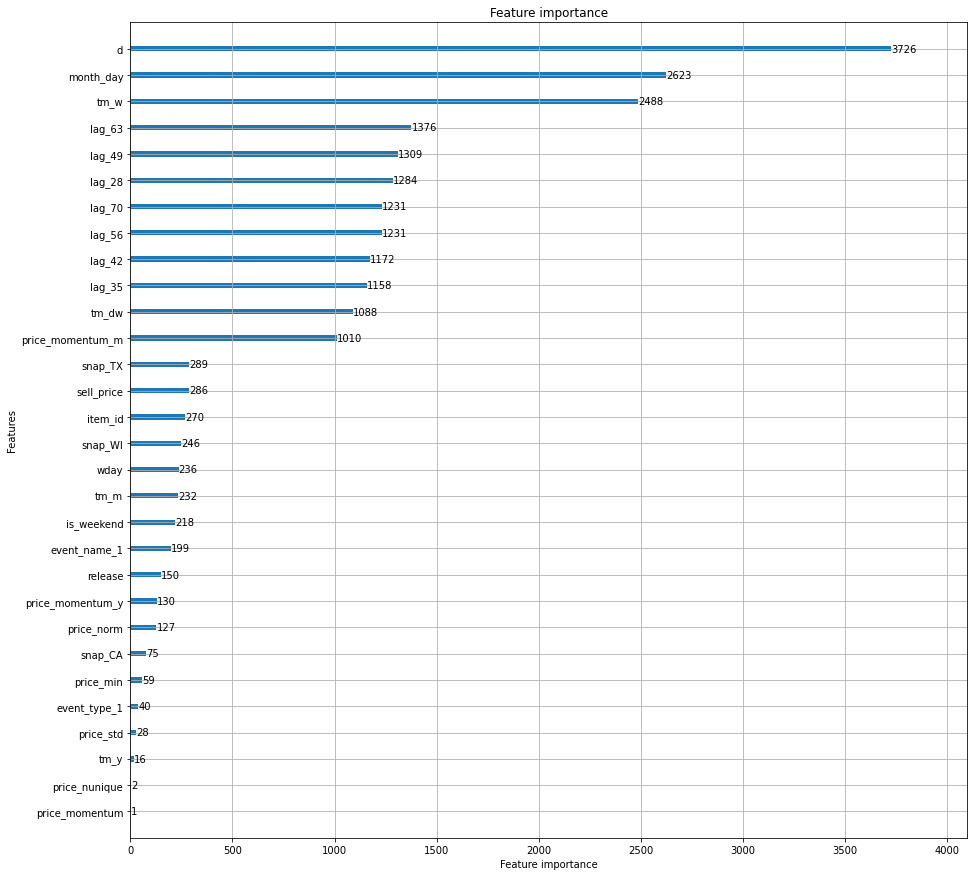

In [ ]:
ax = ltb.plot_importance(lgb, max_num_features=40, figsize=(15,15))
plt.show()